# ECCITE 1D Analysis

In [11]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline

In [12]:
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 500)

In [13]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [14]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'axes.labelsize': 'large'}
pylab.rcParams.update(params)

In [15]:
data_path = '/data_volume/memento/eccite/'

### Read the guide labled perturb-seq data

From perturbseq paper

In [16]:
adata = sc.read(data_path + 'eccite.h5ad')
adata.var.index.name=None

In [17]:
adata.obs.head(2)

,lane,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,orig.ident,nCount_HTO,nFeature_HTO,MULTI_ID,MULTI_classification,replicate,treatment,guide_ID,second_percent,gene
GATCGATGTAACGACG-2,2,4695,20006.0,1006.0,5.028491,SeuratProject,258,8,rep4-tx-TCGATAATGCGA,rep4-tx-TCGATAATGCGA,rep4,tx,IFNGR1g2-CTTTCTGATATCCAGTTTA,0.003125,IFNGR1
AACTCTTCAAGTTCTG-3,3,3789,15422.0,596.0,3.864609,SeuratProject,190,6,rep4-tx-TCGATAATGCGA,rep4-tx-TCGATAATGCGA,rep4,tx,IFNGR1g2-CTTTCTGATATCCAGTTTA,0.007979,IFNGR1


In [18]:
adata.obs['treatment'].value_counts()

tx      25460
ctrl     2886
Name: treatment, dtype: int64

### Read pre-defined ISGs

In [19]:
isg_classes = pd.read_csv('isg_classes.csv')

In [20]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

### Setup memento

In [21]:
adata.obs['q'] = 0.15

In [22]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07 ,trim_percent=0.05)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned
  all_res_var = estimator._residual_variance(all_m, all_v, estimator._fit_mv_regressor(all_m, all_v))


In [23]:
ko_genes = adata.obs.gene.drop_duplicates().tolist()

### Memento - WT vs KO

In [ ]:
for treatment in ['ctrl', 'tx']:
    for g in ko_genes:

        if g == 'NT':
            continue

        subset = adata[adata.obs['gene'].isin(['NT', g]) & (adata.obs['treatment']==treatment)].copy().copy()

        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values
        
        memento.create_groups(subset, label_columns=['is_ko', 'replicate'])

        memento.compute_1d_moments(subset, min_perc_group=.7)

        memento.ht_1d_moments(
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            resampling='permutation',
            approx=False,
            num_cpus=94)

        subset.write(data_path + '1d/{}_{}.h5ad'.format(g, treatment)) 


In [ ]:
for treatment in ['ctrl', 'tx']:
    for g in ko_genes:

        if g == 'NT':
            continue

        subset = adata[adata.obs['gene'].isin(['NT', g]) & (adata.obs['treatment']==treatment)].copy().copy()

        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values
        
        memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

        memento.compute_1d_moments(subset, min_perc_group=.7)

        memento.ht_1d_moments(
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            resampling='bootstrap',
            approx=False,
            num_cpus=94)

        subset.write(data_path + '1d/{}_{}_guide_rep.h5ad'.format(g, treatment)) 


### Memento - ctrl vs stim

In [24]:
subset = adata[adata.obs['gene'].isin(['NT'])].copy().copy()

subset.obs['is_stim'] = (subset.obs['treatment'] == 'tx').astype(int)

memento.create_groups(subset, label_columns=['is_stim', 'replicate'])

memento.compute_1d_moments(subset, min_perc_group=.7)

memento.ht_1d_moments(
    subset, 
    formula_like='1 + is_stim + replicate',
    treatment_col='is_stim', 
    num_boot=10000, 
    verbose=1,
    resampling='permutation',
    approx=False,
    num_cpus=94)



/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.4s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:    7.2s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   11.4s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   16.6s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   22.2s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:   28.7s
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:   36.9s
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:   45.9s
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:   55.5s
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:  1.1min
[Parallel(n_j

In [25]:
stim_ht_df = memento.get_1d_ht_result(subset)
stim_ht_df['de_fdr'] = memento.util._fdrcorrect(stim_ht_df['de_pval'])

In [26]:
thp1_isgs = stim_ht_df.query('de_fdr < 0.05 & de_coef > 1').gene.tolist()

### Analyze 1D - ctrl

In [9]:
results = {}
moments = {}
for treatment in ['ctrl', 'tx']:
    results[treatment] = {}
    moments[treatment] = {}
    for g in ['STAT1']:#ko_genes:
    #     print(g)
        if g == 'NT': continue
        subset = sc.read(data_path +'1d/{}_{}.h5ad'.format(g, treatment))
        df = memento.get_1d_ht_result(subset)
        df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
        df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
        moment_df = memento.get_1d_moments(subset, groupby='is_ko')
        results[treatment][g] = df.copy()
        moments[treatment][g] = (moment_df[0].copy(), moment_df[1].copy())

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log


In [28]:
moment_df = moments['ctrl'][g]

In [35]:
moment_df = moments['ctrl']['STAT1']
ctrl_df = pd.melt(moment_df[1][moment_df[1]['gene'].isin(set(thp1_isgs) & set(t1_isg))], id_vars=['gene'])
ctrl_df['stim'] = 'CTRL'
moment_df = moments['tx']['STAT1']
stim_df = pd.melt(moment_df[1][moment_df[1]['gene'].isin(set(thp1_isgs) & set(t1_isg))], id_vars=['gene'])
stim_df['stim'] = 'IFNG'

In [36]:
combined_df = pd.concat([ctrl_df, stim_df])

In [37]:
combined_df.head(5)

,gene,variable,value,stim
0,ISG15,is_ko_False,2.014224,CTRL
1,IFI6,is_ko_False,2.749943,CTRL
2,MTMR11,is_ko_False,0.879598,CTRL
3,IFI16,is_ko_False,1.361764,CTRL
4,CMPK2,is_ko_False,1.513613,CTRL


In [38]:
combined_df['KO'] = (combined_df['variable']=='is_ko_True')

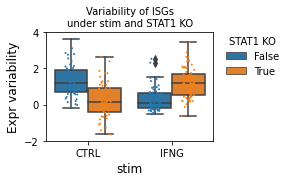

In [40]:
plt.figure(figsize=(3,2))
sns.boxplot(x='stim', y='value', hue='KO', data=combined_df)

ax = sns.stripplot(x='stim', y='value', hue='KO', data=combined_df, lw=1,dodge=True, jitter=0.15, size=2)
handles, labels = ax.get_legend_handles_labels()
plt.ylim(-2, 4)
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='STAT1 KO', frameon=False)
plt.title('Variability of ISGs\nunder stim and STAT1 KO')
plt.ylabel('Expr variability')
plt.savefig('ko_variability.png', bbox_inches='tight', dpi=1000)

In [27]:
# for g in ko_genes:
#     print(g, results[g].query('de_fdr < 0.1').shape[0],results[g].query('dv_fdr < 0.1').shape[0])

In [33]:
df['de_fdr'].min()

0.011924324558855231

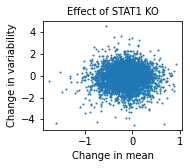

In [29]:
tf = 'STAT1'
plt.figure(figsize=(2.5,2))
plt.scatter(results[tf]['de_coef'], results[tf]['dv_coef'], s=1)
plt.title('Effect of {} KO'.format(tf));
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=5)
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['dv_coef'], s=5)

# plt.savefig('figures/variability_{}.png'.format(tf), bbox_inches='tight', dpi=800)

In [ ]:
plt.figure(figsize=(2.5,2))
plt.scatter(results['STAT1']['de_coef'], results['STAT1']['dv_coef'], s=0.1)
plt.title('Effect of STAT1 KO');
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=1)
# plt.savefig('figures/variability.png', bbox_inches='tight', dpi=800)

In [134]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


### Run coexpression

In [28]:
results = {}
for g in ko_genes:
#     print(g)
    if g == 'NT': continue
    subset = sc.read(data_path +'1d/{}_tx_guide_rep.h5ad'.format(g))
    df = memento.get_1d_ht_result(subset)
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    results[g] = df.copy()

In [29]:
done_files = os.listdir(data_path + '2d/')
for g in ['STAT1', 'STAT2', 'JAK2', 'IFNGR1', 'IFNGR2', 'IRF1']:
    
    for g_ko in ['STAT1', 'STAT2', 'JAK2', 'IFNGR1', 'IFNGR2', 'IRF1']:
        print(g, g_ko)
        
        if g == g_ko or g == 'NT' or g_ko == 'NT': continue
        fname = '{}_with_{}_KO_guide_rep.h5ad'.format(g, g_ko)
        if fname in done_files: continue
        
        subset = adata.copy().copy()

        subset = adata[adata.obs['gene'].isin(['NT', g_ko]) & (adata.obs['treatment']=='tx')].copy().copy()
    
        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values

        memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

        memento.compute_1d_moments(subset, min_perc_group=.7)
        
        if g not in subset.var.index: continue

        available_genes = list(
            set(subset.var.index) & \
            set(results[g].query('de_coef < 0 & de_fdr < 0.05').gene.tolist()) & \
            set(results[g_ko].query('de_coef < 0 & de_fdr < 0.05').gene.tolist())
            )
        
        if len(available_genes) < 10: continue
        memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

        memento.ht_2d_moments( 
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=0,
            num_cpus=94,
            resampling='bootstrap',
            approx=False)
        
        subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g_ko))

STAT1 STAT1
STAT1 STAT2


... storing 'memento_group' as categorical


STAT1 JAK2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


STAT1 IFNGR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


STAT1 IFNGR2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


STAT1 IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


STAT2 STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


STAT2 STAT2
STAT2 JAK2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


STAT2 IFNGR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


STAT2 IFNGR2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


STAT2 IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


JAK2 STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


JAK2 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


JAK2 JAK2
JAK2 IFNGR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


JAK2 IFNGR2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


JAK2 IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR1 STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR1 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR1 JAK2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR1 IFNGR1
IFNGR1 IFNGR2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR1 IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR2 STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR2 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR2 JAK2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR2 IFNGR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IFNGR2 IFNGR2
IFNGR2 IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IRF1 STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IRF1 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IRF1 JAK2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IRF1 IFNGR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IRF1 IFNGR2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical


IRF1 IRF1


In [31]:
done_files = os.listdir(data_path + '2d/')
for g in ko_genes:
    
    for g_ko in ko_genes:
        print(g, g_ko)
        
        if g == g_ko or g == 'NT' or g_ko == 'NT': continue
        fname = '{}_with_{}_KO_guide_rep.h5ad'.format(g, g_ko)
        if fname in done_files: continue
        
        subset = adata.copy().copy()

        subset = adata[adata.obs['gene'].isin(['NT', g_ko]) & (adata.obs['treatment']=='tx')].copy().copy()
    
        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values

        memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

        memento.compute_1d_moments(subset, min_perc_group=.7)
        
        if g not in subset.var.index: continue

        available_genes = list(
            set(subset.var.index) & \
            set(results[g].query('de_coef < 0 & de_fdr < 0.05').gene.tolist()) & \
            set(results[g_ko].query('de_coef < 0 & de_fdr < 0.05').gene.tolist())
            )
        
        if len(available_genes) < 10: continue
        memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

        memento.ht_2d_moments( 
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            num_cpus=94,
            resampling='bootstrap',
            approx=False)
        
        subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g_ko))

IFNGR1 IFNGR1
IFNGR1 IRF7


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 IFNGR2
IFNGR1 CAV1
IFNGR1 STAT3
IFNGR1 CD86
IFNGR1 NT
IFNGR1 CMTM6
IFNGR1 JAK2
IFNGR1 BRD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   4 out of  47 | elapsed:    5.6s remaining:  1.0min
[Parallel(n_jobs=94)]: Done  47 out of  47 | elapsed:    6.8s finished
... storing 'memento_group' as categorical


IFNGR1 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.6s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   19.9s
[Parallel(n_jobs=94)]: Done 591 out of 591 | elapsed:   38.4s finished
... storing 'memento_group' as categorical


IFNGR1 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 PDCD1LG2
IFNGR1 STAT1
IFNGR1 MARCH8
IFNGR1 UBE2L6
IFNGR1 ETV7
IFNGR1 TNFRSF14
IFNGR1 IRF1
IFNGR1 STAT5A
IFNGR1 ATF2
IFNGR1 POU2F2
IFNGR1 STAT2
IFNGR1 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  38 | elapsed:    2.5s remaining:   11.0s
[Parallel(n_jobs=94)]: Done  38 out of  38 | elapsed:    3.6s finished
... storing 'memento_group' as categorical


IFNGR1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    2.9s finished
... storing 'memento_group' as categorical


IFNGR1 SPI1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR1 PDL1
IRF7 IFNGR1
IRF7 IRF7
IRF7 IFNGR2
IRF7 CAV1
IRF7 STAT3
IRF7 CD86
IRF7 NT
IRF7 CMTM6
IRF7 JAK2
IRF7 BRD4
IRF7 SMAD4
IRF7 NFKBIA
IRF7 PDCD1LG2
IRF7 STAT1
IRF7 MARCH8
IRF7 UBE2L6
IRF7 ETV7
IRF7 TNFRSF14
IRF7 IRF1
IRF7 STAT5A
IRF7 ATF2
IRF7 POU2F2
IRF7 STAT2
IRF7 CUL3
IRF7 MYC
IRF7 SPI1
IRF7 PDL1
IFNGR2 IFNGR1
IFNGR2 IRF7
IFNGR2 IFNGR2
IFNGR2 CAV1
IFNGR2 STAT3
IFNGR2 CD86
IFNGR2 NT
IFNGR2 CMTM6
IFNGR2 JAK2
IFNGR2 BRD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  37 out of  44 | elapsed:    3.9s remaining:    0.7s
[Parallel(n_jobs=94)]: Done  44 out of  44 | elapsed:    4.0s finished
... storing 'memento_group' as categorical


IFNGR2 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   24.3s
[Parallel(n_jobs=94)]: Done 572 out of 572 | elapsed:   48.9s finished
... storing 'memento_group' as categorical


IFNGR2 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 PDCD1LG2
IFNGR2 STAT1
IFNGR2 MARCH8
IFNGR2 UBE2L6
IFNGR2 ETV7
IFNGR2 TNFRSF14
IFNGR2 IRF1
IFNGR2 STAT5A
IFNGR2 ATF2
IFNGR2 POU2F2
IFNGR2 STAT2
IFNGR2 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   2 out of  37 | elapsed:    2.9s remaining:   50.7s
[Parallel(n_jobs=94)]: Done  37 out of  37 | elapsed:    5.4s finished
... storing 'memento_group' as categorical


IFNGR2 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    3.1s finished
... storing 'memento_group' as categorical


IFNGR2 SPI1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 PDL1
CAV1 IFNGR1
CAV1 IRF7
CAV1 IFNGR2
CAV1 CAV1
CAV1 STAT3
CAV1 CD86
CAV1 NT
CAV1 CMTM6
CAV1 JAK2
CAV1 BRD4
CAV1 SMAD4
CAV1 NFKBIA
CAV1 PDCD1LG2
CAV1 STAT1
CAV1 MARCH8
CAV1 UBE2L6
CAV1 ETV7
CAV1 TNFRSF14
CAV1 IRF1
CAV1 STAT5A
CAV1 ATF2
CAV1 POU2F2
CAV1 STAT2
CAV1 CUL3
CAV1 MYC
CAV1 SPI1
CAV1 PDL1
STAT3 IFNGR1
STAT3 IRF7
STAT3 IFNGR2
STAT3 CAV1
STAT3 STAT3
STAT3 CD86
STAT3 NT
STAT3 CMTM6
STAT3 JAK2
STAT3 BRD4
STAT3 SMAD4
STAT3 NFKBIA
STAT3 PDCD1LG2
STAT3 STAT1
STAT3 MARCH8
STAT3 UBE2L6
STAT3 ETV7
STAT3 TNFRSF14
STAT3 IRF1
STAT3 STAT5A
STAT3 ATF2
STAT3 POU2F2
STAT3 STAT2
STAT3 CUL3
STAT3 MYC
STAT3 SPI1
STAT3 PDL1
CD86 IFNGR1
CD86 IRF7
CD86 IFNGR2
CD86 CAV1
CD86 STAT3
CD86 CD86
CD86 NT
CD86 CMTM6
CD86 JAK2
CD86 BRD4
CD86 SMAD4
CD86 NFKBIA
CD86 PDCD1LG2
CD86 STAT1
CD86 MARCH8
CD86 UBE2L6
CD86 ETV7
CD86 TNFRSF14
CD86 IRF1
CD86 STAT5A
CD86 ATF2
CD86 POU2F2
CD86 STAT2
CD86 CUL3
CD86 MYC
CD86 SPI1
CD86 PDL1
NT IFNGR1
NT IRF7
NT IFNGR2
NT CAV1
NT STAT3
NT CD86
NT NT
NT CMTM6
NT JAK2
NT 

[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  37 out of  44 | elapsed:    6.2s remaining:    1.2s
[Parallel(n_jobs=94)]: Done  44 out of  44 | elapsed:    6.5s finished
... storing 'memento_group' as categorical


JAK2 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   24.6s
[Parallel(n_jobs=94)]: Done 541 out of 541 | elapsed:   43.8s finished
... storing 'memento_group' as categorical


JAK2 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 PDCD1LG2
JAK2 STAT1
JAK2 MARCH8
JAK2 UBE2L6
JAK2 ETV7
JAK2 TNFRSF14
JAK2 IRF1
JAK2 STAT5A
JAK2 ATF2
JAK2 POU2F2
JAK2 STAT2
JAK2 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  34 out of  36 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  36 out of  36 | elapsed:    3.9s finished
... storing 'memento_group' as categorical


JAK2 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  12 | elapsed:    2.4s remaining:    1.7s
[Parallel(n_jobs=94)]: Done  12 out of  12 | elapsed:    3.0s finished
... storing 'memento_group' as categorical


JAK2 SPI1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 PDL1
BRD4 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   8 out of  48 | elapsed:    3.5s remaining:   17.4s
[Parallel(n_jobs=94)]: Done  48 out of  48 | elapsed:    5.8s finished
... storing 'memento_group' as categorical


BRD4 IRF7


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  37 out of  44 | elapsed:    4.4s remaining:    0.8s
[Parallel(n_jobs=94)]: Done  44 out of  44 | elapsed:    5.0s finished
... storing 'memento_group' as categorical


BRD4 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 STAT3
BRD4 CD86
BRD4 NT
BRD4 CMTM6
BRD4 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  37 out of  44 | elapsed:    4.0s remaining:    0.7s
[Parallel(n_jobs=94)]: Done  44 out of  44 | elapsed:    4.4s finished
... storing 'memento_group' as categorical


BRD4 BRD4
BRD4 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  19 out of  68 | elapsed:    3.9s remaining:   10.0s
[Parallel(n_jobs=94)]: Done  68 out of  68 | elapsed:    5.7s finished
... storing 'memento_group' as categorical


BRD4 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 PDCD1LG2
BRD4 STAT1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 out of  24 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=94)]: Done  24 out of  24 | elapsed:    3.1s finished
... storing 'memento_group' as categorical


BRD4 MARCH8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 UBE2L6
BRD4 ETV7
BRD4 TNFRSF14
BRD4 IRF1
BRD4 STAT5A
BRD4 ATF2
BRD4 POU2F2
BRD4 STAT2
BRD4 CUL3
BRD4 MYC
BRD4 SPI1
BRD4 PDL1
SMAD4 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.2s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   19.2s
[Parallel(n_jobs=94)]: Done 592 out of 592 | elapsed:   38.3s finished
... storing 'memento_group' as categorical


SMAD4 IRF7


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   17.6s
[Parallel(n_jobs=94)]: Done 572 out of 572 | elapsed:   33.8s finished
... storing 'memento_group' as categorical


SMAD4 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 STAT3
SMAD4 CD86
SMAD4 NT
SMAD4 CMTM6
SMAD4 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   16.0s
[Parallel(n_jobs=94)]: Done 541 out of 541 | elapsed:   29.3s finished
... storing 'memento_group' as categorical


SMAD4 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  19 out of  68 | elapsed:    2.6s remaining:    6.8s
[Parallel(n_jobs=94)]: Done  68 out of  68 | elapsed:    4.1s finished
... storing 'memento_group' as categorical


SMAD4 SMAD4
SMAD4 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 PDCD1LG2
SMAD4 STAT1
SMAD4 MARCH8
SMAD4 UBE2L6
SMAD4 ETV7
SMAD4 TNFRSF14
SMAD4 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  90 out of 138 | elapsed:    7.0s remaining:    3.7s
[Parallel(n_jobs=94)]: Done 138 out of 138 | elapsed:    9.6s finished
... storing 'memento_group' as categorical


SMAD4 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


SMAD4 ATF2
SMAD4 POU2F2
SMAD4 STAT2
SMAD4 CUL3
SMAD4 MYC
SMAD4 SPI1
SMAD4 PDL1
NFKBIA IFNGR1
NFKBIA IRF7
NFKBIA IFNGR2
NFKBIA CAV1
NFKBIA STAT3
NFKBIA CD86
NFKBIA NT
NFKBIA CMTM6
NFKBIA JAK2
NFKBIA BRD4
NFKBIA SMAD4
NFKBIA NFKBIA
NFKBIA PDCD1LG2
NFKBIA STAT1
NFKBIA MARCH8
NFKBIA UBE2L6
NFKBIA ETV7
NFKBIA TNFRSF14
NFKBIA IRF1
NFKBIA STAT5A
NFKBIA ATF2
NFKBIA POU2F2
NFKBIA STAT2
NFKBIA CUL3
NFKBIA MYC
NFKBIA SPI1
NFKBIA PDL1
PDCD1LG2 IFNGR1
PDCD1LG2 IRF7
PDCD1LG2 IFNGR2
PDCD1LG2 CAV1
PDCD1LG2 STAT3
PDCD1LG2 CD86
PDCD1LG2 NT
PDCD1LG2 CMTM6
PDCD1LG2 JAK2
PDCD1LG2 BRD4
PDCD1LG2 SMAD4
PDCD1LG2 NFKBIA
PDCD1LG2 PDCD1LG2
PDCD1LG2 STAT1
PDCD1LG2 MARCH8
PDCD1LG2 UBE2L6
PDCD1LG2 ETV7
PDCD1LG2 TNFRSF14
PDCD1LG2 IRF1
PDCD1LG2 STAT5A
PDCD1LG2 ATF2
PDCD1LG2 POU2F2
PDCD1LG2 STAT2
PDCD1LG2 CUL3
PDCD1LG2 MYC
PDCD1LG2 SPI1
PDCD1LG2 PDL1
STAT1 IFNGR1
STAT1 IRF7
STAT1 IFNGR2
STAT1 CAV1
STAT1 STAT3
STAT1 CD86
STAT1 NT
STAT1 CMTM6
STAT1 JAK2
STAT1 BRD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 out of  24 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=94)]: Done  24 out of  24 | elapsed:    3.5s finished
... storing 'memento_group' as categorical


STAT1 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    7.7s
[Parallel(n_jobs=94)]: Done 394 out of 394 | elapsed:   36.5s finished
... storing 'memento_group' as categorical


STAT1 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 PDCD1LG2
STAT1 STAT1
STAT1 MARCH8
STAT1 UBE2L6
STAT1 ETV7
STAT1 TNFRSF14
STAT1 IRF1
STAT1 STAT5A
STAT1 ATF2
STAT1 POU2F2
STAT1 STAT2
STAT1 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   4 out of  31 | elapsed:    3.1s remaining:   21.1s
[Parallel(n_jobs=94)]: Done  31 out of  31 | elapsed:    3.7s finished
... storing 'memento_group' as categorical


STAT1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT1 SPI1
STAT1 PDL1
MARCH8 IFNGR1
MARCH8 IRF7
MARCH8 IFNGR2
MARCH8 CAV1
MARCH8 STAT3
MARCH8 CD86
MARCH8 NT
MARCH8 CMTM6
MARCH8 JAK2
MARCH8 BRD4
MARCH8 SMAD4
MARCH8 NFKBIA
MARCH8 PDCD1LG2
MARCH8 STAT1
MARCH8 MARCH8
MARCH8 UBE2L6
MARCH8 ETV7
MARCH8 TNFRSF14
MARCH8 IRF1
MARCH8 STAT5A
MARCH8 ATF2
MARCH8 POU2F2
MARCH8 STAT2
MARCH8 CUL3
MARCH8 MYC
MARCH8 SPI1
MARCH8 PDL1
UBE2L6 IFNGR1
UBE2L6 IRF7
UBE2L6 IFNGR2
UBE2L6 CAV1
UBE2L6 STAT3
UBE2L6 CD86
UBE2L6 NT
UBE2L6 CMTM6
UBE2L6 JAK2
UBE2L6 BRD4
UBE2L6 SMAD4
UBE2L6 NFKBIA
UBE2L6 PDCD1LG2
UBE2L6 STAT1
UBE2L6 MARCH8
UBE2L6 UBE2L6
UBE2L6 ETV7
UBE2L6 TNFRSF14
UBE2L6 IRF1
UBE2L6 STAT5A
UBE2L6 ATF2
UBE2L6 POU2F2
UBE2L6 STAT2
UBE2L6 CUL3
UBE2L6 MYC
UBE2L6 SPI1
UBE2L6 PDL1
ETV7 IFNGR1
ETV7 IRF7
ETV7 IFNGR2
ETV7 CAV1
ETV7 STAT3
ETV7 CD86
ETV7 NT
ETV7 CMTM6
ETV7 JAK2
ETV7 BRD4
ETV7 SMAD4
ETV7 NFKBIA
ETV7 PDCD1LG2
ETV7 STAT1
ETV7 MARCH8
ETV7 UBE2L6
ETV7 ETV7
ETV7 TNFRSF14
ETV7 IRF1
ETV7 STAT5A
ETV7 ATF2
ETV7 POU2F2
ETV7 STAT2
ETV7 CUL3
ETV7 MYC
ETV7 SPI

[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  90 out of 138 | elapsed:   14.0s remaining:    7.5s
[Parallel(n_jobs=94)]: Done 138 out of 138 | elapsed:   17.5s finished
... storing 'memento_group' as categorical


IRF1 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 PDCD1LG2
IRF1 STAT1
IRF1 MARCH8
IRF1 UBE2L6
IRF1 ETV7
IRF1 TNFRSF14
IRF1 IRF1
IRF1 STAT5A
IRF1 ATF2
IRF1 POU2F2
IRF1 STAT2
IRF1 CUL3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  16 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=94)]: Done  16 out of  16 | elapsed:    3.4s finished
... storing 'memento_group' as categorical


IRF1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1 SPI1
IRF1 PDL1
STAT5A IFNGR1
STAT5A IRF7
STAT5A IFNGR2
STAT5A CAV1
STAT5A STAT3
STAT5A CD86
STAT5A NT
STAT5A CMTM6
STAT5A JAK2
STAT5A BRD4
STAT5A SMAD4
STAT5A NFKBIA
STAT5A PDCD1LG2
STAT5A STAT1
STAT5A MARCH8
STAT5A UBE2L6
STAT5A ETV7
STAT5A TNFRSF14
STAT5A IRF1
STAT5A STAT5A
STAT5A ATF2
STAT5A POU2F2
STAT5A STAT2
STAT5A CUL3
STAT5A MYC
STAT5A SPI1
STAT5A PDL1
ATF2 IFNGR1
ATF2 IRF7
ATF2 IFNGR2
ATF2 CAV1
ATF2 STAT3
ATF2 CD86
ATF2 NT
ATF2 CMTM6
ATF2 JAK2
ATF2 BRD4
ATF2 SMAD4
ATF2 NFKBIA
ATF2 PDCD1LG2
ATF2 STAT1
ATF2 MARCH8
ATF2 UBE2L6
ATF2 ETV7
ATF2 TNFRSF14
ATF2 IRF1
ATF2 STAT5A
ATF2 ATF2
ATF2 POU2F2
ATF2 STAT2
ATF2 CUL3
ATF2 MYC
ATF2 SPI1
ATF2 PDL1
POU2F2 IFNGR1
POU2F2 IRF7
POU2F2 IFNGR2
POU2F2 CAV1
POU2F2 STAT3
POU2F2 CD86
POU2F2 NT
POU2F2 CMTM6
POU2F2 JAK2
POU2F2 BRD4
POU2F2 SMAD4
POU2F2 NFKBIA
POU2F2 PDCD1LG2
POU2F2 STAT1
POU2F2 MARCH8
POU2F2 UBE2L6
POU2F2 ETV7
POU2F2 TNFRSF14
POU2F2 IRF1
POU2F2 STAT5A
POU2F2 ATF2
POU2F2 POU2F2
POU2F2 STAT2
POU2F2 CUL3
POU2F2 MYC
POU2F2 SPI1
PO

[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  20 out of  20 | elapsed:    3.5s finished
... storing 'memento_group' as categorical


STAT2 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 PDCD1LG2
STAT2 STAT1
STAT2 MARCH8
STAT2 UBE2L6
STAT2 ETV7
STAT2 TNFRSF14
STAT2 IRF1
STAT2 STAT5A
STAT2 ATF2
STAT2 POU2F2
STAT2 STAT2
STAT2 CUL3
STAT2 MYC
STAT2 SPI1
STAT2 PDL1
CUL3 IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  38 | elapsed:    2.8s remaining:   12.3s
[Parallel(n_jobs=94)]: Done  38 out of  38 | elapsed:    4.9s finished
... storing 'memento_group' as categorical


CUL3 IRF7


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   2 out of  37 | elapsed:    2.1s remaining:   35.9s
[Parallel(n_jobs=94)]: Done  37 out of  37 | elapsed:    4.1s finished
... storing 'memento_group' as categorical


CUL3 CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 STAT3
CUL3 CD86
CUL3 NT
CUL3 CMTM6
CUL3 JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  34 out of  36 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  36 out of  36 | elapsed:    3.8s finished
... storing 'memento_group' as categorical


CUL3 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  33 | elapsed:    2.8s remaining:    3.0s
[Parallel(n_jobs=94)]: Done  33 out of  33 | elapsed:    3.6s finished
... storing 'memento_group' as categorical


CUL3 NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 PDCD1LG2
CUL3 STAT1
CUL3 MARCH8
CUL3 UBE2L6
CUL3 ETV7
CUL3 TNFRSF14
CUL3 IRF1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  16 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=94)]: Done  16 out of  16 | elapsed:    3.3s finished
... storing 'memento_group' as categorical


CUL3 STAT5A


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CUL3 ATF2
CUL3 POU2F2
CUL3 STAT2
CUL3 CUL3
CUL3 MYC
CUL3 SPI1
CUL3 PDL1
MYC IFNGR1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    5.0s finished
... storing 'memento_group' as categorical


MYC IRF7


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=94)]: Done  10 out of  10 | elapsed:    4.1s finished
... storing 'memento_group' as categorical


MYC CAV1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC STAT3
MYC CD86
MYC NT
MYC CMTM6
MYC JAK2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  12 | elapsed:    2.4s remaining:    1.7s
[Parallel(n_jobs=94)]: Done  12 out of  12 | elapsed:    3.8s finished
... storing 'memento_group' as categorical


MYC BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC SMAD4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   7 out of  14 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=94)]: Done  14 out of  14 | elapsed:    3.6s finished
... storing 'memento_group' as categorical


MYC NFKBIA


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


MYC PDCD1LG2
MYC STAT1
MYC MARCH8
MYC UBE2L6
MYC ETV7
MYC TNFRSF14
MYC IRF1
MYC STAT5A
MYC ATF2
MYC POU2F2
MYC STAT2
MYC CUL3
MYC MYC
MYC SPI1
MYC PDL1
SPI1 IFNGR1
SPI1 IRF7
SPI1 IFNGR2
SPI1 CAV1
SPI1 STAT3
SPI1 CD86
SPI1 NT
SPI1 CMTM6
SPI1 JAK2
SPI1 BRD4
SPI1 SMAD4
SPI1 NFKBIA
SPI1 PDCD1LG2
SPI1 STAT1
SPI1 MARCH8
SPI1 UBE2L6
SPI1 ETV7
SPI1 TNFRSF14
SPI1 IRF1
SPI1 STAT5A
SPI1 ATF2
SPI1 POU2F2
SPI1 STAT2
SPI1 CUL3
SPI1 MYC
SPI1 SPI1
SPI1 PDL1
PDL1 IFNGR1
PDL1 IRF7
PDL1 IFNGR2
PDL1 CAV1
PDL1 STAT3
PDL1 CD86
PDL1 NT
PDL1 CMTM6
PDL1 JAK2
PDL1 BRD4
PDL1 SMAD4
PDL1 NFKBIA
PDL1 PDCD1LG2
PDL1 STAT1
PDL1 MARCH8
PDL1 UBE2L6
PDL1 ETV7
PDL1 TNFRSF14
PDL1 IRF1
PDL1 STAT5A
PDL1 ATF2
PDL1 POU2F2
PDL1 STAT2
PDL1 CUL3
PDL1 MYC
PDL1 SPI1
PDL1 PDL1


### Check TF's correlation to other genes following KO

In [123]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'CUL3', 'IFNGR1', 'IFNGR2', 'MYC', 'SMAD4']
done_files = os.listdir(data_path + '/2d/')
for g in ['JAK2']:#ko_genes:
    
    if g == 'NT': continue
    fname = '{}_with_{}_KO_guide_rep.h5ad'.format(g, g)
#         if fname in done_files: continue

    subset = adata.copy().copy()

    subset = adata[adata.obs['gene'].isin(['NT', g])].copy().copy()

    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values

    memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

    memento.compute_1d_moments(subset, min_perc_group=.7)

    if g not in subset.var.index: continue

    available_genes = list(set(subset.var.index))

    if len(available_genes) < 10: continue
    memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

    memento.ht_2d_moments( 
        subset, 
        formula_like='1 + is_ko + replicate',
        treatment_col='is_ko', 
        num_boot=10000, 
        verbose=1,
        num_cpus=14,
        resampling='bootstrap',
        approx=False)

    subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:106: RuntimeWarning: divide by zero encountered in log
  rv[cond] = np.exp(np.log(var[cond]) - f(np.log(mean[cond])))


In [124]:
moments, counts = memento.get_2d_moments(subset)

In [131]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


In [127]:
dv_genes = results['JAK2'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

In [120]:
subset.obs['STAT1'] = subset[:, 'STAT1'].X.todense().A1
subset.obs['GBP4'] = subset[:, 'GBP4'].X.todense().A1

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [70]:
dv_genes = results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

### Debugging
